In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
# Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [5]:
import shutil

SOURCE_PATH = r'C:\Users\91901\Desktop\PAYAL\Face Recongnition\archive\lfw-deepfunneled\lfw-deepfunneled'

# Destination path for negative images
NEG_PATH = os.path.join('data', 'negative')

# Traverse through each subfolder
for person_folder in os.listdir(SOURCE_PATH):
    person_path = os.path.join(SOURCE_PATH, person_folder)
    if os.path.isdir(person_path):
        for image_file in os.listdir(person_path):
            src_file = os.path.join(person_path, image_file)
            dst_file = os.path.join(NEG_PATH, image_file)
            
            # Only move the file if it doesn't already exist in the destination folder
            if not os.path.exists(dst_file):
                shutil.move(src_file, dst_file)


In [6]:
import cv2

In [7]:
# Import uuid library to generate unique image names
import uuid

In [8]:

os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\24ea6c94-20d5-11f0-ade1-9408533a25a6.jpg'

In [9]:
cap = cv2.VideoCapture(0)  # Try changing to 0, 1, or 2 if needed

while True:
    ret, frame = cap.read()

    #cut down frame to 250x250 px
    frame = frame[120:120+250,200:200+250,:]

    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [11]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\750f619f-187c-11f0-9d2e-9408533a25a6.jpg'


In [12]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [13]:
img = preprocess('data\\anchor\\71d19341-187c-11f0-8bde-9408533a25a6.jpg')

In [14]:
img.numpy().max()

0.74191177

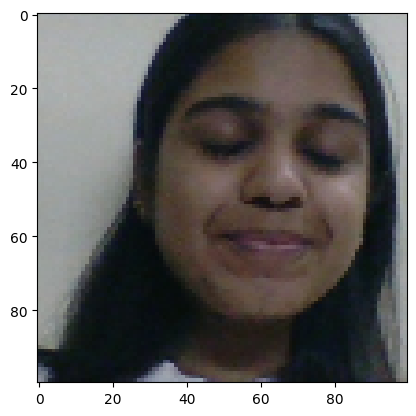

In [15]:
plt.imshow(img)

Creating positive/negative pairs

In [16]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
samples = data.as_numpy_iterator()
exampple = samples.next()

In [18]:
exampple

(b'data\\anchor\\563e4415-1e6c-11f0-aced-9408533a25a6.jpg',
 b'data\\positive\\a04683d6-1e6e-11f0-a56d-9408533a25a6.jpg',
 1.0)

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_twin(*exampple)

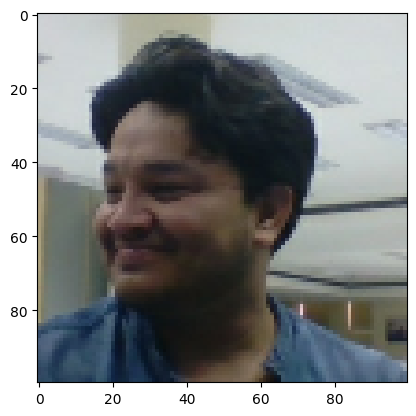

In [21]:
plt.imshow(res[1])

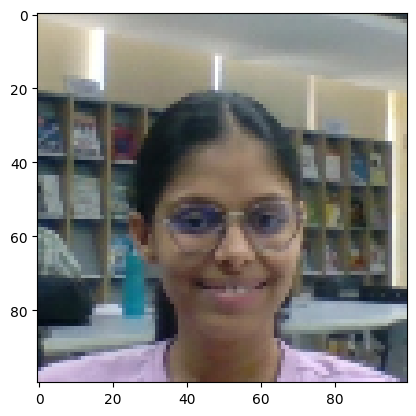

In [22]:
plt.imshow(res[0])

In [23]:
res[2]

1.0

In [24]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [25]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [26]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [27]:
inp = Input(shape=(100,100,3), name='input_image')

Embedding Layers

In [28]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [29]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [30]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [31]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [32]:
l1= L1Dist()
l1

In [33]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
classifier
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [34]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [35]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [36]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [37]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [38]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.],
      dtype=float32)

In [39]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [40]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [41]:
train_loss_results = []
train_precision_results = []
train_recall_results = []

def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        r = Recall()
        p = Precision()
        epoch_loss_avg = tf.keras.metrics.Mean()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            epoch_loss_avg.update_state(loss)
            progbar.update(idx+1)
        
        # Store metrics
        train_loss_results.append(epoch_loss_avg.result().numpy())
        train_precision_results.append(p.result().numpy())
        train_recall_results.append(r.result().numpy())

        print("Loss: {:.4f}, Recall: {:.4f}, Precision: {:.4f}".format(
            epoch_loss_avg.result().numpy(), r.result().numpy(), p.result().numpy()))

        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)


In [42]:
EPOCHS = 20
train(train_data, EPOCHS)


 Epoch 1/20
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
8/8 [==============================] - 170s 21s/step
Loss: 0.6371, Recall: 0.1129, Precision: 1.0000

 Epoch 2/20
8/8 [==============================] - 159s 20s/step
Loss: 0.4949, Recall: 0.2632, Precision: 1.0000

 Epoch 3/20
8/8 [==============================] - 166s 21s/step
Loss: 0.3921, Recall: 0.7333, Precision: 0.9778

 Epoch 4/20
8/8 [==============================] - 156s 20s/step
Loss: 0.2482, Recall: 0.9286, Precision: 0.9811

 Epoch 5/20
8/8 [==============================] - 161s 20s/step
Loss: 0.1747, Recall: 0.8596, Precision: 1.0000

 Epoch 6/20
8/8 [==============================] - 158s 20s/step
Loss: 0.1339, Recall: 0.9821, Precision: 1.0000

 Epoch 7/20
8/8 [==============================] - 163s 20s/step
Loss: 0.0966, Recall: 0.9661, Precision: 1.0000

 Epoch 8/20
8/8 [==============================

In [43]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [44]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]
[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]
y_true

1/1 [==============================] - 1s 1s/step


array([0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

In [45]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [46]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [47]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 442ms/step
1.0 1.0


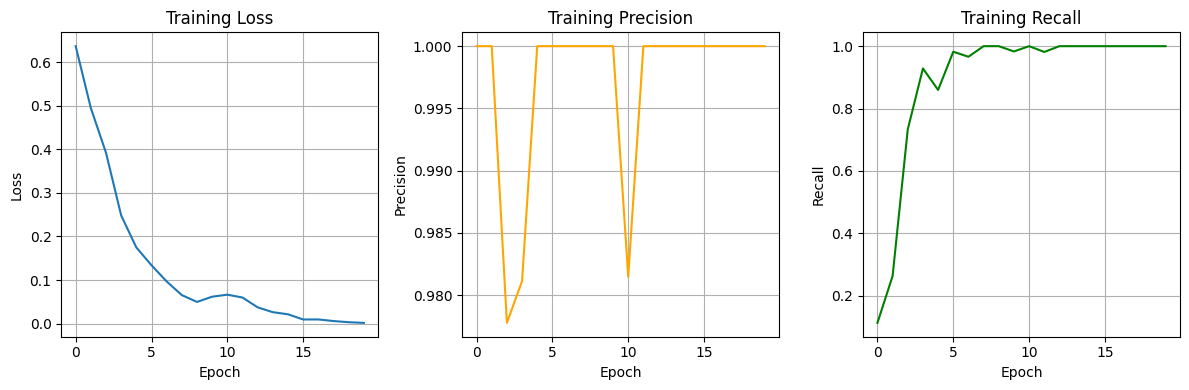

In [48]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_loss_results, label='Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_precision_results, label='Precision', color='orange')
plt.title("Training Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(train_recall_results, label='Recall', color='green')
plt.title("Training Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.grid(True)

plt.tight_layout()
plt.show()


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for test_batch in test_data:
    imgs, labels = test_batch[:2], test_batch[2]
    preds = siamese_model.predict(imgs)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.round(preds).numpy().flatten())

print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


1/1 [==============================] - 0s 443ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       1.00      1.00      1.00        23

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54

Confusion Matrix:
 [[31  0]
 [ 0 23]]


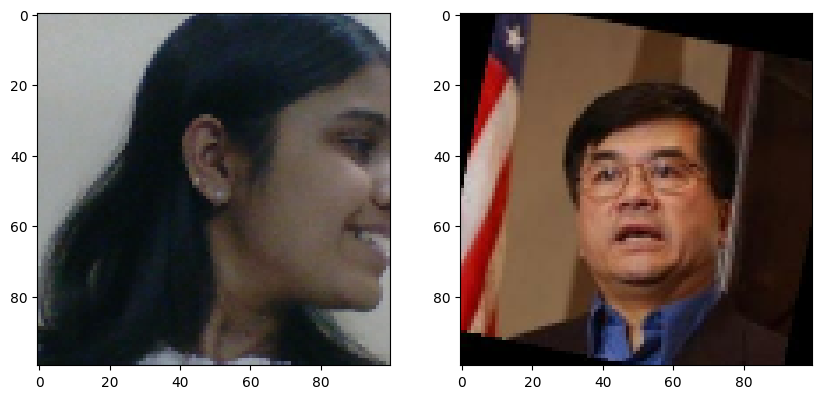

In [50]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [51]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [52]:
L1Dist

__main__.L1Dist

In [53]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [54]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 612ms/step


array([[2.4368049e-08],
       [9.9725330e-01],
       [9.9999934e-01],
       [1.5101631e-04],
       [9.9771190e-01],
       [9.9998689e-01]], dtype=float32)

In [55]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

Verification Function

In [56]:

os.listdir(os.path.join('application_data', 'verification_images'))
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [57]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 230ms/step
True
1/1 [==============================] - 0s 216ms/step
True
1/1 [==============================] - 0s 249ms/step
True
1/1 [==============================] - 0s 255ms/step
False
1/1 [==============================] - 0s 241ms/step
False
1/1 [==============================] - 0s 248ms/step
False


In [62]:
np.sum(np.squeeze(results) > 0.5)

10

In [63]:
results

[array([[0.94401413]], dtype=float32),
 array([[0.949485]], dtype=float32),
 array([[0.05604418]], dtype=float32),
 array([[0.9997303]], dtype=float32),
 array([[0.9964403]], dtype=float32),
 array([[0.00805368]], dtype=float32),
 array([[0.00546399]], dtype=float32),
 array([[0.1628695]], dtype=float32),
 array([[0.00536571]], dtype=float32),
 array([[0.00804904]], dtype=float32),
 array([[0.9964728]], dtype=float32),
 array([[0.09735192]], dtype=float32),
 array([[0.9901246]], dtype=float32),
 array([[0.98560554]], dtype=float32),
 array([[0.01289868]], dtype=float32),
 array([[0.03890292]], dtype=float32),
 array([[0.00638342]], dtype=float32),
 array([[0.99433655]], dtype=float32),
 array([[0.0215167]], dtype=float32),
 array([[0.16801374]], dtype=float32),
 array([[0.11526795]], dtype=float32),
 array([[0.27978614]], dtype=float32),
 array([[0.01968839]], dtype=float32),
 array([[0.9762856]], dtype=float32),
 array([[0.09573873]], dtype=float32),
 array([[0.04139367]], dtype=float